# Calculating temporal variance with and without seasonal cycle

In [2]:
using CABLAB
using ImageMagick

A Cube is defined via its path and some a single variable is read into memory.

In [3]:
c             = Cube("/Net/Groups/BGI/scratch/DataCube/v1/brockmann-consult.de/datacube/")
cdata         = getCubeData(c,variable="SoilMoisture",latitude=(35,65), longitude=(-15,40));

Here we demonstrate how to add a user-defined function to use the DAT's capabilities. First we define the function that has the signature *xin* (input data), *xout* (output data), *maskin* (input mask), *maskout* (output mask). In this case it simply cacluates the variance of a time series. Then we call the @registerDATFunction macro, which creates a wrapper around the function and makes it applicable to a Cube object. 

In [4]:
function varianceTime{T}(xout::AbstractArray{T,0},maskout::AbstractArray{UInt8,0},xin::AbstractVector{T},maskin::AbstractVector)
  s=zero(T)
  s2=zero(T)*zero(T)
  n=0
  for i in eachindex(xin)
    if maskin[i]==CABLAB.VALID
      s+=xin[i]
      s2+=xin[i]*xin[i]
      n+=1
    end
  end
  if n>0
    m=s/n
    v=s2/n-m*m
    xout[1]=v
    maskout[1]=CABLAB.VALID
  else
    maskout[1]=CABLAB.MISSING
  end
end

CABLAB.DAT.registerDATFunction(varianceTime,(TimeAxis,));

Here we call the function with our 3D data cube as its argument.

In [5]:
v1             = mapCube(varianceTime,cdata);
cube_anomalies = mapCube(removeMSC,cdata,46);
v2             = mapCube(varianceTime,cube_anomalies);

We get the spatial mean of the time variances

And show the maps of variances:

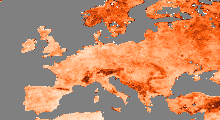

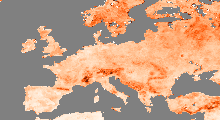

In [6]:
plotMAP(v1,dmin=0.0f0,dmax=0.01f0)
plotMAP(v2,dmin=0.0f0,dmax=0.01f0)

In [7]:
mv1=mapCube(spatialMean,(v1,v1.axes[2]))
mv2=mapCube(spatialMean,(v2,v2.axes[2]))
println("Mean variance with seasonal cycle: ", mv1.data[1])
println("Mean variance without seasonal cycle: ", mv2.data[1])

Mean variance with seasonal cycle: 0.008488666
Mean variance without seasonal cycle: 0.006032313


Interact.Slider{Int64}(Signal{Int64}(253, nactions=0),"Time Step",253,1:506,true)

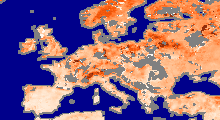

In [8]:
plotMAP(cdata)